In [1]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error
from kmodes.kprototypes import KPrototypes

from time import time

pd.set_option("display.max_columns", None)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#On modifie les options pour rendre l'affichage des float plus lisible
pd.set_option('float_format', '{:f}'.format)

## Import des datasets fournis par le client

In [3]:
df_customers = pd.read_csv("olist_customers_dataset.csv", sep=',')
df_geolocation = pd.read_csv("olist_geolocation_dataset.csv", sep=',')
df_order_items = pd.read_csv("olist_order_items_dataset.csv", sep=',')
df_order_payments = pd.read_csv("olist_order_payments_dataset.csv", sep=',')
df_order_reviews = pd.read_csv("olist_order_reviews_dataset.csv", sep=',')
df_orders = pd.read_csv("olist_orders_dataset.csv", sep=',')
df_products = pd.read_csv("olist_products_dataset.csv", sep=',')
df_sellers = pd.read_csv("olist_sellers_dataset.csv", sep=',')
df_category_name_translation = pd.read_csv("product_category_name_translation.csv", sep=',')

### Analyse de chaque dataset

In [4]:
df_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


Dans ce dataset on retrouve l'identifiant unique de nos clients, ce qui va nous permettre de faire le lien entre les clients et leurs commandes. On retrouve également leur ville et l'état dans lequel ils vivent, on pourra peut etre faire des stats sur ces donnée.

In [5]:
df_geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


Ici on a la localisation en coordonnées gps des différentes commandes, on ne vas probablement pas les utiliser car on a déjà les villes reliées aux commandes

In [6]:
df_order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.900000,13.290000
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.900000,19.930000
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.000000,17.870000
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.990000,12.790000
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.900000,18.140000
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.990000,43.410000
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.000000,36.530000
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.900000,16.950000
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.990000,8.720000


Ici on a les informations concernant les commandes, dont l'identifiant du client, l'identifiant de la commande, son coût ainsi que les frais de ports.
Il pourrait être intéressant de faire des statistiques sur ces données.

In [7]:
df_order_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.330000
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.390000
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.710000
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.780000
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.450000
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.310000
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.800000
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.770000
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.540000


In [8]:
df_order_payments["payment_type"].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

Ici on a les moyens de paiement pour chaque transactions, ainsi que leur cout total (commande + frais de port).

Ces moyens de paiement comprennent: carde de crédit, espèces, coupon, carte de débit, non défini.

In [9]:
df_order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


Ici nous avons les avis des clients pour chaque commande, ces données seront très intéressantes à exploiter car nous pourrons analyser l'impact d'une note négative d'un client sur son comportement d'achat.

In [10]:
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


Ici on a tout ce qui concerne les dates de commandes ainsi que leur statut. On pourra utiliser ces données pour établir une fréquence d'achats chez les clients

In [11]:
df_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.000000,287.000000,1.000000,225.000000,16.000000,10.000000,14.000000
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.000000,276.000000,1.000000,1000.000000,30.000000,18.000000,20.000000
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.000000,250.000000,1.000000,154.000000,18.000000,9.000000,15.000000
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.000000,261.000000,1.000000,371.000000,26.000000,4.000000,26.000000
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.000000,402.000000,4.000000,625.000000,20.000000,17.000000,13.000000
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.000000,67.000000,2.000000,12300.000000,40.000000,40.000000,40.000000
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.000000,971.000000,1.000000,1700.000000,16.000000,19.000000,16.000000
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.000000,799.000000,1.000000,1400.000000,27.000000,7.000000,27.000000
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.000000,156.000000,2.000000,700.000000,31.000000,13.000000,20.000000


Ici on a tous les produits disponibles avec leur caractéristiques (taille, poids, nombre de photos du produit)

In [12]:
df_sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


Ici on a les villes de chaques revendeur, ces données ne seront pas intéressantes car nous avons déjà la localisation par commandes et on va se concentrer sur les clients et non les revendeurs

In [13]:
df_category_name_translation

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


Ici on a la traduction de chaque catégorie de produit vers l'anglais, ce que l'on va utiliser car je maitrise bien mieux l'anglais

## Merge des datasets

In [14]:
df_customers = pd.merge(df_geolocation, df_customers,
                        right_on=["customer_zip_code_prefix",
                                  "customer_city", "customer_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city", "geolocation_state"],
                        how="right")
df_customers.drop(["geolocation_zip_code_prefix", "geolocation_city",
                   "geolocation_state"], axis=1, inplace=True)
df_customers = df_customers[["customer_id", "customer_unique_id",
                             "customer_city", "geolocation_lat",
                             "geolocation_lng"]]

df_customers.drop_duplicates(subset="customer_unique_id",
                             inplace=True)

df_customers.head()

,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.509897,-47.397866
147,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,-23.726853,-46.545746
300,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,-23.527788,-46.660310
387,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,-23.496930,-46.185352
520,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,-22.987222,-47.151073


In [15]:
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [16]:
df = pd.merge(df_customers,
              df_orders,
              left_on="customer_id",
              right_on="customer_id",
              how="right")
df.drop_duplicates(subset="customer_id",
                   inplace=True)

df.head()

,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,-12.169860,-44.988369,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,-16.746337,-48.514624,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,-5.767733,-35.275467,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,-23.675037,-46.524784,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [17]:
df = pd.merge(df_order_reviews,
              df,
              left_on="order_id",
              right_on="order_id",
              how="right")

df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,a54f0611adc9ed256b57ede6b6eb5114,e481f51cbdc54678b7cc49136f2d6af7,4.000000,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,8d5266042046a06655c8db133d120ba5,53cdb2fc8bc7dce0b6741e2150273451,4.000000,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,-12.169860,-44.988369,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,e73b67b67587f7644d5bd1a52deb1b01,47770eb9100c2d0c44946d9cf07ec65d,5.000000,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,-16.746337,-48.514624,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,359d03e676b3c069f62cadba8dd3f6e8,949d5b44dbf5de918fe9c16f97b45f8a,5.000000,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,-5.767733,-35.275467,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,e50934924e227544ba8246aeb3770dd4,ad21c59c0840e6cb83a9ceb5573f8159,5.000000,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,-23.675037,-46.524784,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [18]:
df = pd.merge(df_order_payments,
              df,
              left_on="order_id",
              right_on="order_id",
              how="right")

df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,1.000000,credit_card,1.000000,18.120000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,e481f51cbdc54678b7cc49136f2d6af7,3.000000,voucher,1.000000,2.000000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
2,e481f51cbdc54678b7cc49136f2d6af7,2.000000,voucher,1.000000,18.590000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
3,53cdb2fc8bc7dce0b6741e2150273451,1.000000,boleto,1.000000,141.460000,8d5266042046a06655c8db133d120ba5,4.000000,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,-12.169860,-44.988369,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
4,47770eb9100c2d0c44946d9cf07ec65d,1.000000,credit_card,3.000000,179.120000,e73b67b67587f7644d5bd1a52deb1b01,5.000000,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,-16.746337,-48.514624,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


### Vérification de l'intégrité des données

In [19]:
df = df.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [20]:
df["payment_value"].isnull().sum().sum()

1

On vérifie que chacune des transactions possède bien un montant et on supprimes les lignes n'en contenant pas afin d'avoir des données entièrement exploitables

In [21]:
df.dropna(subset=["payment_value"], inplace=True)
df["payment_value"].isnull().sum().sum()

0

<AxesSubplot:>

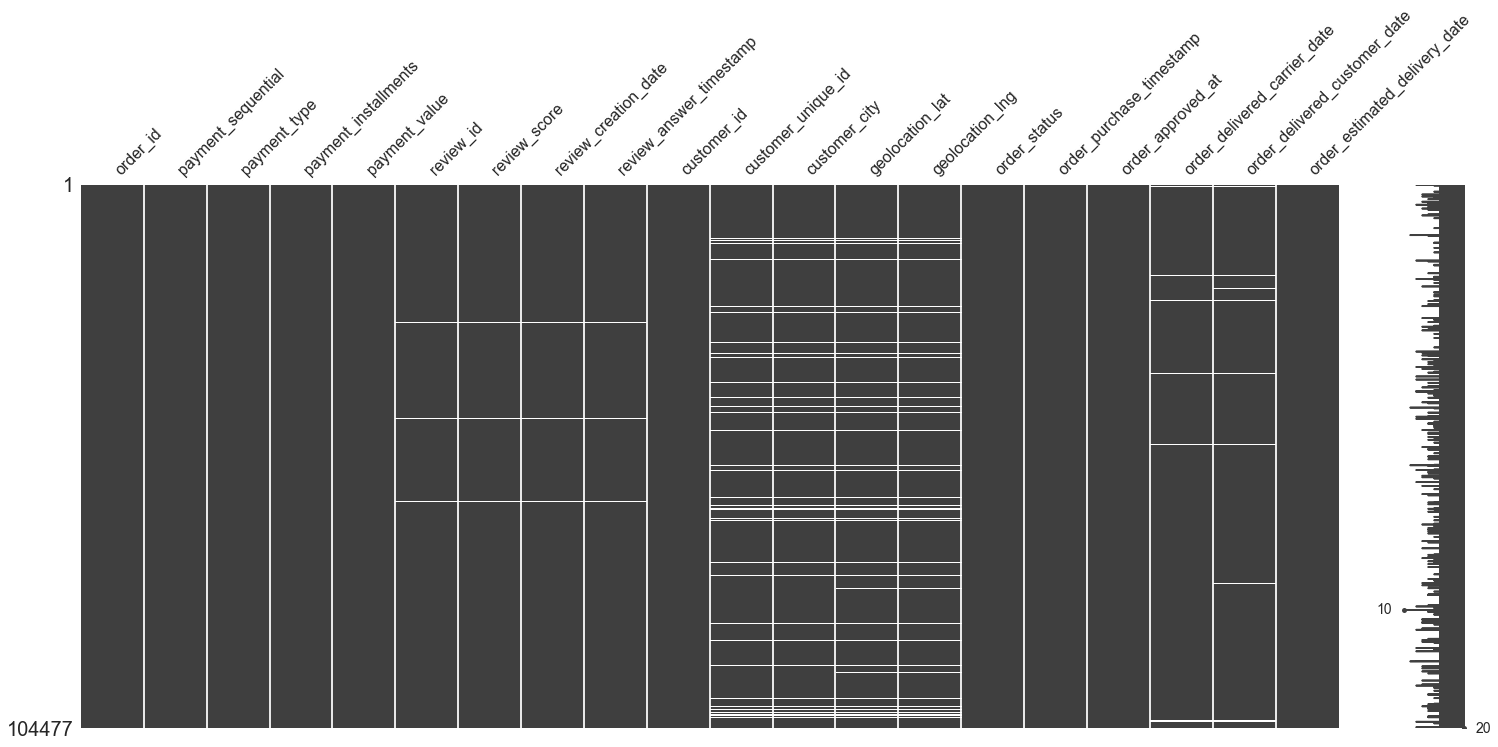

In [22]:
msno.matrix(df)

In [23]:
df["customer_unique_id"].describe()

count                               100697
unique                               96095
top       8af7ac63b2efbcbd88e5b11505e8098a
freq                                    29
Name: customer_unique_id, dtype: object

In [24]:
nb_achats = df['customer_unique_id'].value_counts().value_counts()
nb_achats

1     92958
2      2576
3       283
4       112
5        49
6        37
7        28
8        10
9         9
11        7
10        6
12        6
13        3
14        2
15        2
19        2
26        1
21        1
22        1
24        1
29        1
Name: customer_unique_id, dtype: int64

<AxesSubplot:>

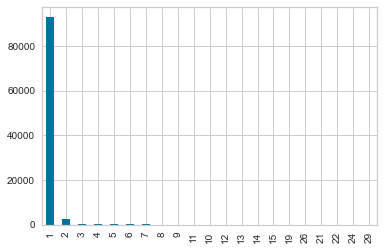

In [25]:
nb_achats.plot(kind='bar')

In [26]:
recurrent_customers = 96095 - 92959
recurrent_customers

3136

In [27]:
percent_recurrent_customers = 3136*100/100698
percent_recurrent_customers

3.114262448112177

Nous avons donc seulement 3.11% des clients qui ont fait au moins 2 commandes 

In [28]:
df["payment_value"].describe()

count   104477.000000
mean       153.923071
std        217.120187
min          0.000000
25%         56.780000
50%        100.000000
75%        171.690000
max      13664.080000
Name: payment_value, dtype: float64

<AxesSubplot:xlabel='payment_value', ylabel='Density'>

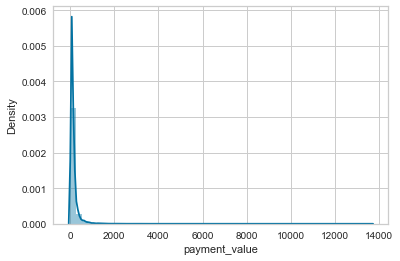

In [29]:
sns.distplot(df.payment_value)

<AxesSubplot:xlabel='payment_value', ylabel='Density'>

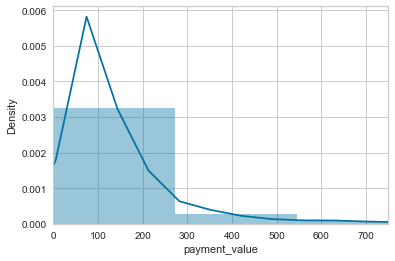

In [30]:
plt.xlim([0, 750])

sns.distplot(df.payment_value)

## Création de la segmentation RFM

Nous allons créer une segmentation RFM sur les clients afin d'identifier des segments de clients homogènes afin de proposer un ciblage marketing sur ceux ci

### Conversion des types de dates en datetime

Les formats de dates semblent déjà correspondre au forma datetime mais nous allons forcer une conversion afin d'être sur d'avoir un format correct

In [31]:
time_cols = ["order_purchase_timestamp", "order_approved_at",
            "order_delivered_carrier_date", "order_delivered_customer_date",
            "order_estimated_delivery_date"]

for cols in time_cols:
    df[cols] = pd.to_datetime(df[cols],
                              format="%Y-%m-%d", errors="ignore")

In [32]:
df["delivery_time"] = df["order_delivered_customer_date"] - df["order_purchase_timestamp"]

In [33]:
df["delivery_time"] = pd.to_timedelta(df["delivery_time"])

In [34]:
df["delivery_time"] = df["delivery_time"] / pd.offsets.Day(1)

In [35]:
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,1.000000,credit_card,1.000000,18.120000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574
1,e481f51cbdc54678b7cc49136f2d6af7,3.000000,voucher,1.000000,2.000000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574
2,e481f51cbdc54678b7cc49136f2d6af7,2.000000,voucher,1.000000,18.590000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574
3,53cdb2fc8bc7dce0b6741e2150273451,1.000000,boleto,1.000000,141.460000,8d5266042046a06655c8db133d120ba5,4.000000,2018-08-08 00:00:00,2018-08-08 18:37:50,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,-12.169860,-44.988369,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.782037
4,47770eb9100c2d0c44946d9cf07ec65d,1.000000,credit_card,3.000000,179.120000,e73b67b67587f7644d5bd1a52deb1b01,5.000000,2018-08-18 00:00:00,2018-08-22 19:07:58,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,-16.746337,-48.514624,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.394213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,1.000000,credit_card,3.000000,85.080000,e262b3f92d1ce917aa412a9406cf61a6,5.000000,2017-03-22 00:00:00,2017-03-23 11:02:08,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,sao jose dos campos,-23.172205,-45.880056,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009
104474,63943bddc261676b46f01ca7ac2f7bd8,1.000000,credit_card,3.000000,195.000000,29bb71b2760d0f876dfa178a76bc4734,4.000000,2018-03-01 00:00:00,2018-03-02 17:50:01,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,praia grande,-24.001467,-46.446355,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.193727
104475,83c1379a015df1e13d02aae0204711ab,1.000000,credit_card,5.000000,271.010000,371579771219f6db2d830d50805977bb,5.000000,2017-09-22 00:00:00,2017-09-22 23:10:57,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,-17.891522,-39.370942,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.859421
104476,11c177c8e97725db2631073c19f07b62,1.000000,credit_card,4.000000,441.160000,8ab6855b9fe9b812cd03a480a25058a1,2.000000,2018-01-26 00:00:00,2018-01-27 09:16:56,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,japuiba,-22.555985,-42.690761,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.086424


### Etude de l'impact du temps de livraison sur les avis

<AxesSubplot:>

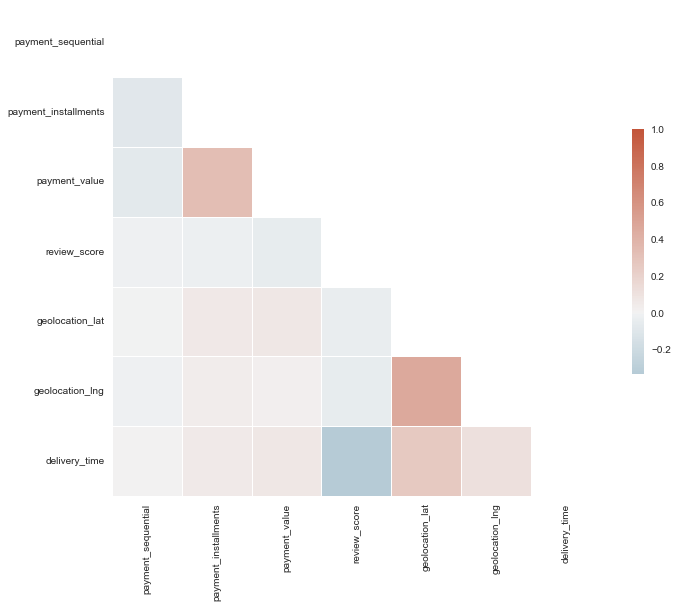

In [36]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

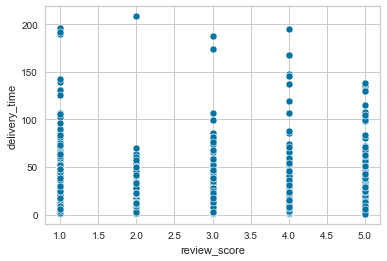

In [37]:
dfSample = df.sample(50000)  # Nous prenons un échantillon de 50 000 entités pour accélérer le processus
xdataSample, ydataSample = df["review_score"], dfSample["delivery_time"]

sns.scatterplot(data=dfSample, x="review_score", y="delivery_time")
plt.show()

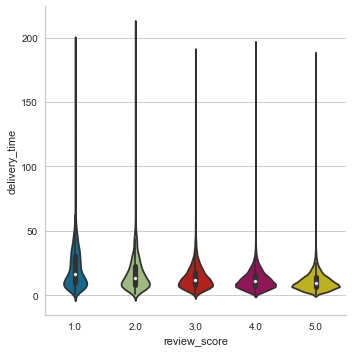

In [38]:
sns.catplot(data=df, kind="violin", x="review_score", y="delivery_time", split=True)

<AxesSubplot:xlabel='review_score', ylabel='delivery_time'>

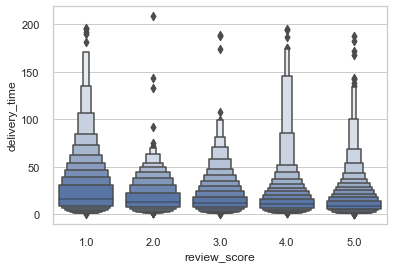

In [39]:
sns.set_theme(style="whitegrid")

sns.boxenplot(x="review_score", y="delivery_time",
              color="b",
              scale="linear", data=df)

In [40]:
mean_delivery_time_per_reviews = {}
for i in range(1, 6):
    temp = df.loc[df['review_score'] == i]
    print("durée moyenne de livraison pour une note de ", i, " : ", temp["delivery_time"].mean())
    mean_delivery_time_per_reviews[i] = temp["delivery_time"].mean()

durée moyenne de livraison pour une note de  1  :  21.256505870464352
durée moyenne de livraison pour une note de  2  :  16.740610391146085
durée moyenne de livraison pour une note de  3  :  14.232420406839527
durée moyenne de livraison pour une note de  4  :  12.33492755532315
durée moyenne de livraison pour une note de  5  :  10.702742256619622


In [41]:
mean_delivery_time_per_reviews

{1: 21.256505870464352,
 2: 16.740610391146085,
 3: 14.232420406839527,
 4: 12.33492755532315,
 5: 10.702742256619622}

[Text(0.5, 0, 'review'),
 Text(0, 0.5, 'delivery time (days)'),
 Text(0.5, 1.0, 'mean delivery time by reviews')]

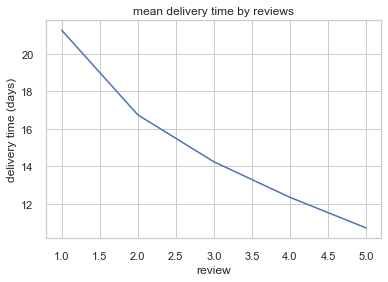

In [42]:
my_df = pd.DataFrame(mean_delivery_time_per_reviews.items())
ax = sns.lineplot(x=0, y=1, data=my_df)
ax.set(xlabel='review', ylabel='delivery time (days)', title='mean delivery time by reviews')

On voit donc clairement que le temps de moyen de livraison semble être un élément majeur dans la notation des clients. 

### ANOVA entre les avis et le temps de livraison

Afin de valider l'importance du temps de livraison dans la notation des clients nous allons procéder à une ANOVA

###### Distribution des avis par rapport temps de livraison

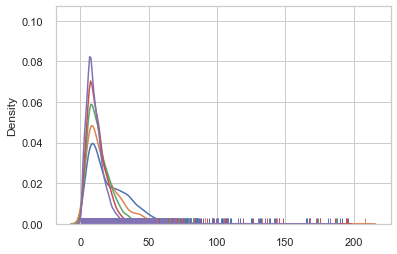

In [43]:

# Sort the dataframe by target
target_1 = df.loc[df['review_score'] == 1]
target_2 = df.loc[df['review_score'] == 2]
target_3 = df.loc[df['review_score'] == 3]
target_4 = df.loc[df['review_score'] == 4]
target_5 = df.loc[df['review_score'] == 5]

sns.distplot(target_1[['delivery_time']], hist=False, rug=True)
sns.distplot(target_2[['delivery_time']], hist=False, rug=True)
sns.distplot(target_3[['delivery_time']], hist=False, rug=True)
sns.distplot(target_4[['delivery_time']], hist=False, rug=True)
sns.distplot(target_5[['delivery_time']], hist=False, rug=True)

plt.show()

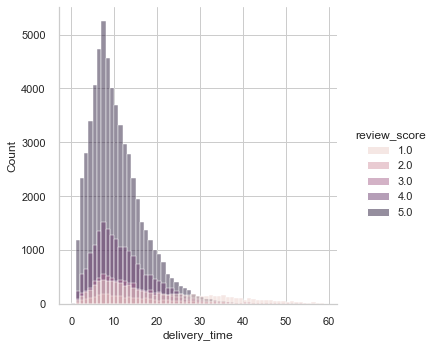

In [44]:
bins_limit = list(range(60))
sns.displot(df, x="delivery_time", hue="review_score", bins=bins_limit)

In [45]:
df["order_purchase_timestamp"]

0        2017-10-02 10:56:33
1        2017-10-02 10:56:33
2        2017-10-02 10:56:33
3        2018-07-24 20:41:37
4        2018-08-08 08:38:49
                 ...        
104473   2017-03-09 09:54:05
104474   2018-02-06 12:58:58
104475   2017-08-27 14:46:43
104476   2018-01-08 21:28:27
104477   2018-03-08 20:57:30
Name: order_purchase_timestamp, Length: 104477, dtype: datetime64[ns]

In [46]:
first_date = df["order_purchase_timestamp"].min()
last_date = df["order_purchase_timestamp"].max()

In [47]:
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)
snapshot_date

Timestamp('2018-10-18 17:30:18')

In [48]:
rfm_customers = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})

rfm_customers.columns = ["Récence", "Fréquence", "Montant"]
data = rfm_customers.copy().reset_index()

In [49]:
data['r_quartile'] = pd.qcut(data['Récence'], 4, ['1', '2', '3', '4'])
data['f_bins'] = pd.cut(data['Fréquence'], 2, labels=['2', '1'])
data['m_quartile'] = pd.qcut(data['Montant'], 4, ['4', '3', '2', '1'])

In [50]:
data['RFM_Score'] = data["r_quartile"].astype(str) \
                    + data["f_bins"].astype(str) \
                    + data["m_quartile"].astype(str)
data.sort_values("RFM_Score", ascending=True)

,customer_unique_id,Récence,Fréquence,Montant,r_quartile,f_bins,m_quartile,RFM_Score
42174,7020078859b9015b76e7469322c2c415,77,1,190.400000,1,2,1,121
46944,7cc8c55781241cb0699be8b935e8e5a2,141,1,357.900000,1,2,1,121
88914,eca9d15ebd1b37acb67bd1c3e3ca5b2c,78,1,405.030000,1,2,1,121
9164,18360e41b00709cc7b2c6f391eff829e,121,1,1839.050000,1,2,1,121
46965,7cd747a15b6eb374e2706259c27e96a8,158,1,309.570000,1,2,1,121
...,...,...,...,...,...,...,...,...
53217,8df1329b564044430fe684b6632f0c8a,595,1,58.460000,4,2,4,424
53216,8df10be00a35becbb4993496f949d948,589,1,45.640000,4,2,4,424
91541,f3cb4bf78563e8f29fb8df63f3ae2748,473,1,51.140000,4,2,4,424
53276,8e1c8e08724097b43730e4344f3200db,472,1,45.610000,4,2,4,424


In [51]:
data["Récence"].describe()

count   96095.000000
mean      290.107727
std       153.607874
min         1.000000
25%       166.000000
50%       271.000000
75%       400.000000
max       773.000000
Name: Récence, dtype: float64

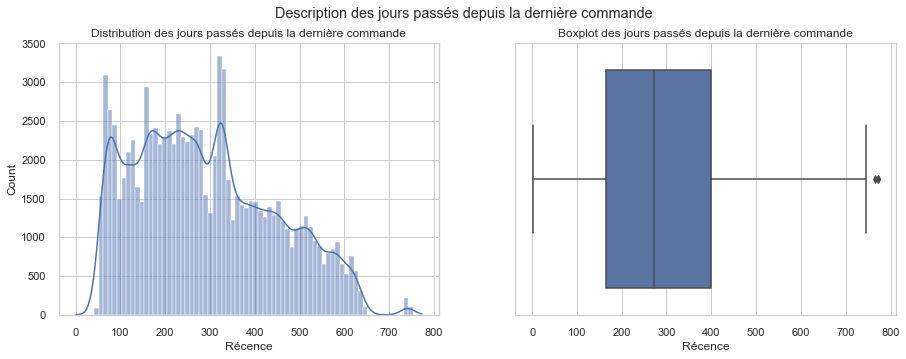

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des jours passés depuis la dernière commande')

sns.histplot(ax=axes[0], x="Récence", data=data, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="Récence", data=data)
axes[1].set_title("Boxplot des jours passés depuis la dernière commande")

plt.show()

On peut constater que le nombre de jours passés depuis la dernière commande est majoritairement situé entre 150 et 400 jours pour les clients, avec une moyenne de 290 jours et une médiane de 270 jours.

In [53]:
data["Fréquence"].describe()

count   96095.000000
mean        1.047890
std         0.392178
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        29.000000
Name: Fréquence, dtype: float64

In [54]:
nb_achats

1     92958
2      2576
3       283
4       112
5        49
6        37
7        28
8        10
9         9
11        7
10        6
12        6
13        3
14        2
15        2
19        2
26        1
21        1
22        1
24        1
29        1
Name: customer_unique_id, dtype: int64

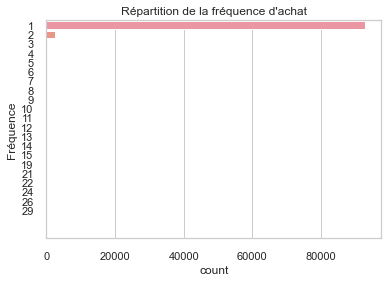

In [55]:
sns.countplot(y="Fréquence", data=data)
plt.ylim(23)
plt.title("Répartition de la fréquence d'achat")

plt.show()

On peut constater que la plupart des clients ne commandent qu'une ou deux fois. 

In [56]:
data["Montant"].describe()

count   96095.000000
mean      158.636702
std       220.154652
min         0.000000
25%        60.235000
50%       103.420000
75%       175.080000
max     13664.080000
Name: Montant, dtype: float64

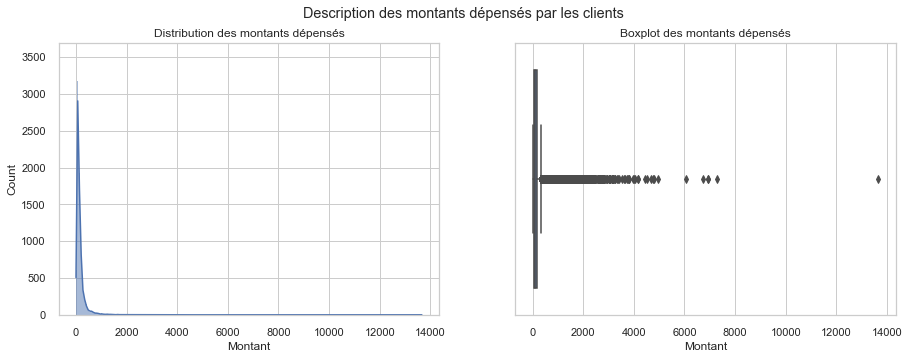

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0], x="Montant", data=data, kde=True)
axes[0].set_title("Distribution des montants dépensés")

sns.boxplot(ax=axes[1], x="Montant", data=data)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

#### Binarisation de la fréquence

In [58]:
data["Fréquence"] = np.where(data["Fréquence"] > 1, 1, 0)

In [59]:
data["Fréquence"].describe()

count   96095.000000
mean        0.032645
std         0.177706
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Fréquence, dtype: float64

In [60]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10, 10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data_pca = data[["Récence", "Fréquence", "Montant"]]

X = data_pca.values
features = data_pca.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

In [62]:
data_pca["Fréquence"].describe()

count   96095.000000
mean        0.032645
std         0.177706
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Fréquence, dtype: float64

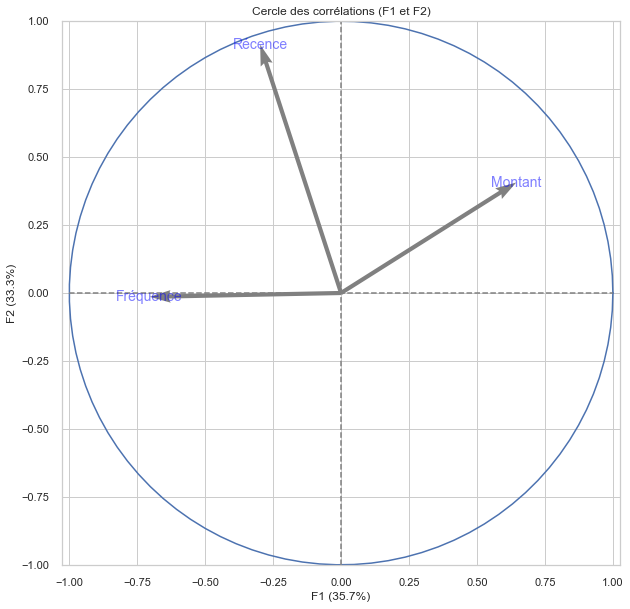

In [63]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

In [64]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.style import set_palette

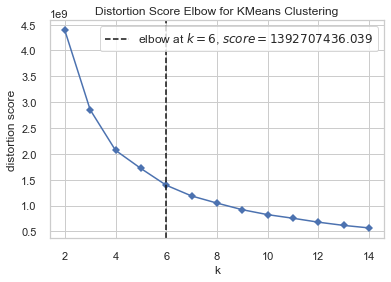

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric='distortion', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [66]:
'''
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
#Kmeans Clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters:
    #Initializing the clusterer with n_clusters value and a random   generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    #The silhouette_score gives the average value for all the   samples.
    #Calculating number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)
    #Using Silhouette Plot
    visualizer = SilhouetteVisualizer(clusterer,colors='yellowbrick')
    #Fit the data to the visualizer
    visualizer.fit(X)
    #Render the figure
    visualizer.show()
    '''

'\nfrom sklearn.metrics import silhouette_score\nfrom yellowbrick.cluster import SilhouetteVisualizer\n#Kmeans Clustering\nrange_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]\nfor n_clusters in range_n_clusters:\n    #Initializing the clusterer with n_clusters value and a random   generator\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10)\n    cluster_labels = clusterer.fit_predict(X)\n    #The silhouette_score gives the average value for all the   samples.\n    #Calculating number of clusters\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)\n    #Using Silhouette Plot\n    visualizer = SilhouetteVisualizer(clusterer,colors=\'yellowbrick\')\n    #Fit the data to the visualizer\n    visualizer.fit(X)\n    #Render the figure\n    visualizer.show()\n    '

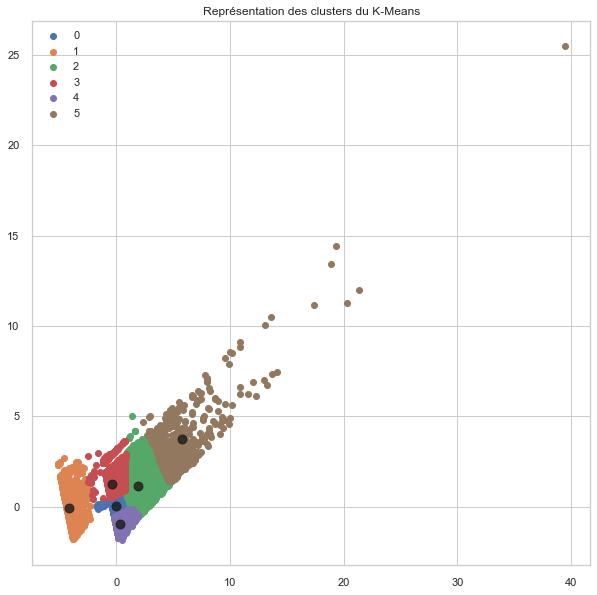

In [67]:
km = KMeans(n_clusters=6)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [68]:
data["clusters"] = km.labels_
for i in range(0, len(data['clusters'].unique())):
    print("Nombre de clients dans le cluster n°", i, " : ", data['customer_unique_id'].loc[data['clusters'] == i].count())

Nombre de clients dans le cluster n° 0  :  33751
Nombre de clients dans le cluster n° 1  :  3107
Nombre de clients dans le cluster n° 2  :  3523
Nombre de clients dans le cluster n° 3  :  21141
Nombre de clients dans le cluster n° 4  :  34091
Nombre de clients dans le cluster n° 5  :  482


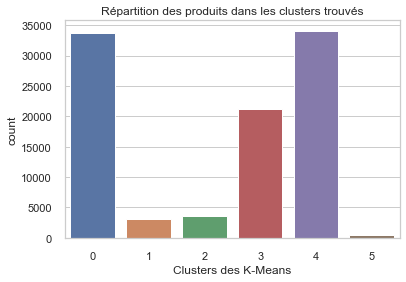

In [69]:
sns.countplot(x="clusters", data=data)
plt.xlabel("Clusters des K-Means")
plt.title("Répartition des produits dans les clusters trouvés")
plt.show()

In [70]:
clusters_stats = data.groupby("clusters").mean()
clusters_stats

,Récence,Fréquence,Montant
clusters,,,
0,304.710438,0.000237,127.385725
1,314.350821,1.000000,72.904300
2,292.508657,0.000568,764.871079
3,509.225723,0.000946,133.375453
4,136.959315,0.000000,122.869457
5,314.943983,0.000000,2106.246183


In [71]:
rfmr_customers = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean",
    "review_score" : "mean",
    "delivery_time" : "mean"
})

rfmr_customers.columns = ["Récence", "Fréquence", "Montant","Avis","Delivery_time"]
data_review = rfmr_customers.copy().reset_index()

In [72]:
data_review["Fréquence"] = np.where(data_review["Fréquence"] > 1, 1, 0)

In [73]:
data_review

,customer_unique_id,Récence,Fréquence,Montant,Avis,Delivery_time
0,0000366f3b9a7992bf8c76cfdf3221e2,161,0,141.900000,5.000000,6.411227
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,0,27.190000,4.000000,3.285590
2,0000f46a3911fa3c0805444483337064,586,0,86.220000,3.000000,25.731759
3,0000f6ccb0745a6a4b88665a16c9f078,370,0,43.620000,4.000000,20.037083
4,0004aac84e0df4da2b147fca70cf8255,337,0,196.890000,5.000000,13.141134
...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,496,0,2067.420000,5.000000,27.514861
96091,fffea47cd6d3cc0a88bd621562a9d061,311,0,84.580000,4.000000,30.097500
96092,ffff371b4d645b6ecea244b27531430a,618,0,112.460000,5.000000,14.872083
96093,ffff5962728ec6157033ef9805bacc48,169,0,133.690000,5.000000,11.858854


In [74]:
data_review.dropna(subset=["Avis"], inplace=True)
data_review["Avis"].isnull().sum().sum()

0

In [75]:
data_review["Delivery_time"].describe()

count   92637.000000
mean       12.528078
std         9.497348
min         0.533414
25%         6.759514
50%        10.203588
75%        15.694664
max       208.351759
Name: Delivery_time, dtype: float64

In [76]:
data_review["Delivery_time"].isnull().sum()

2717

In [77]:
data_review = data_review[data_review['Delivery_time'].notna()]
data_review["Delivery_time"].isnull().sum()

0

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data_pca = data_review[["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

X = data_pca.values
features = data_pca.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

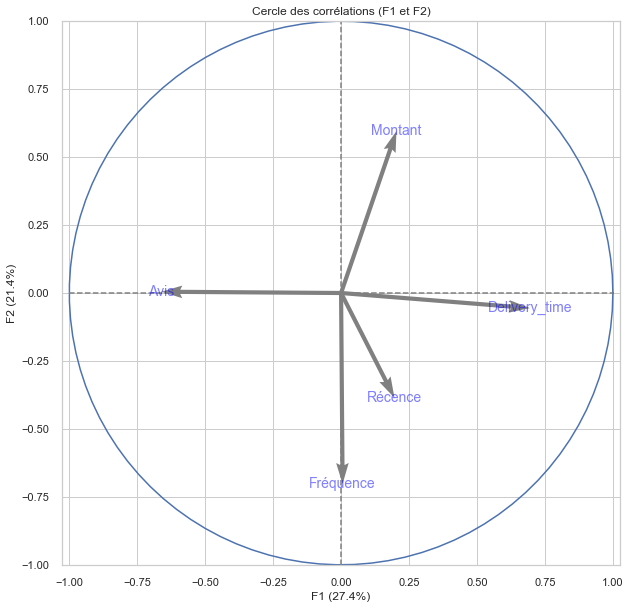

In [79]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

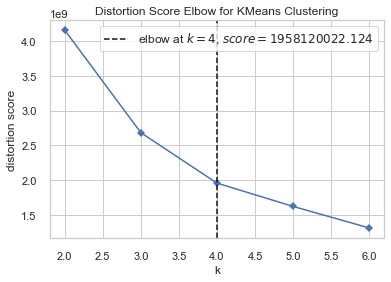

In [80]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 7), metric='distortion', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [81]:
'''
#Kmeans Clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters:
    #Initializing the clusterer with n_clusters value and a random   generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    #The silhouette_score gives the average value for all the   samples.
    #Calculating number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)
    #Using Silhouette Plot
    visualizer = SilhouetteVisualizer(clusterer,colors='yellowbrick')
    #Fit the data to the visualizer
    visualizer.fit(X)
    #Render the figure
    visualizer.show()
    '''

'\n#Kmeans Clustering\nrange_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]\nfor n_clusters in range_n_clusters:\n    #Initializing the clusterer with n_clusters value and a random   generator\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10)\n    cluster_labels = clusterer.fit_predict(X)\n    #The silhouette_score gives the average value for all the   samples.\n    #Calculating number of clusters\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)\n    #Using Silhouette Plot\n    visualizer = SilhouetteVisualizer(clusterer,colors=\'yellowbrick\')\n    #Fit the data to the visualizer\n    visualizer.fit(X)\n    #Render the figure\n    visualizer.show()\n    '

### Stabilité du clustering inter-seed

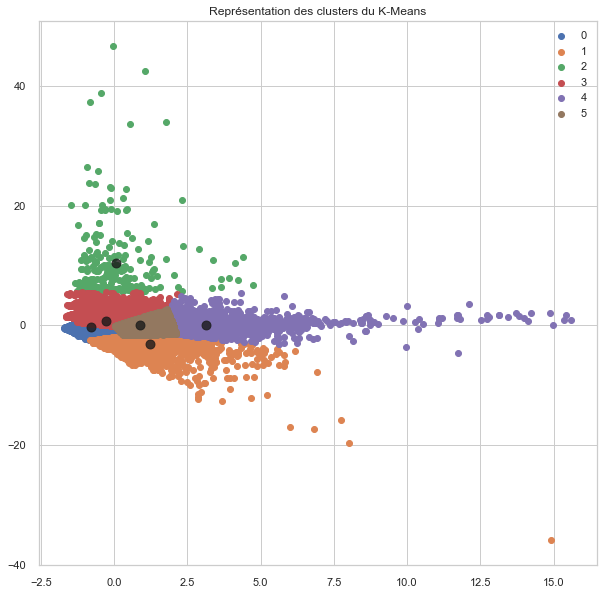

In [127]:
km = KMeans(n_clusters=6, random_state=1)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels_1 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_1:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

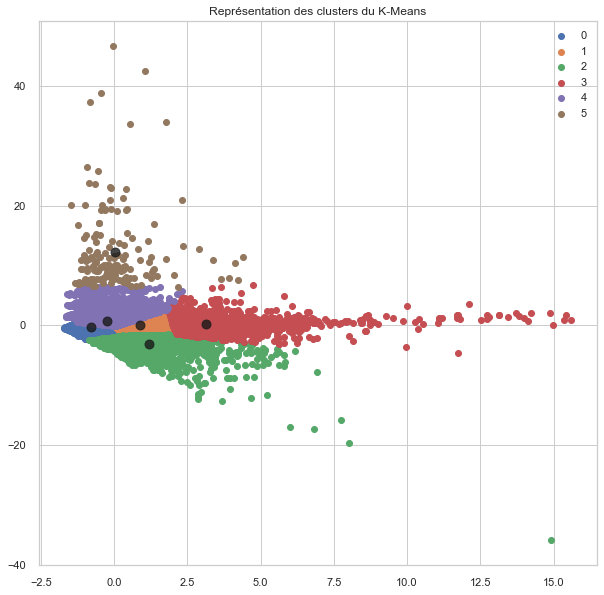

In [128]:
km = KMeans(n_clusters=6, random_state=2)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels_2 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_2:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

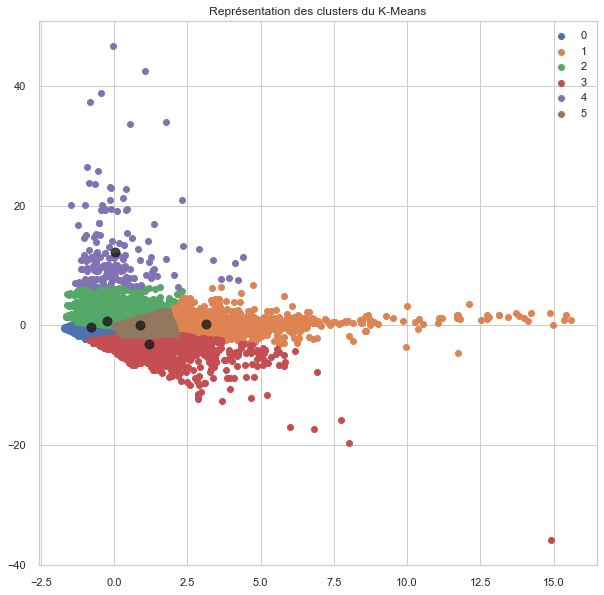

In [120]:
km = KMeans(n_clusters=6, random_state=3)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels_3 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_3:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

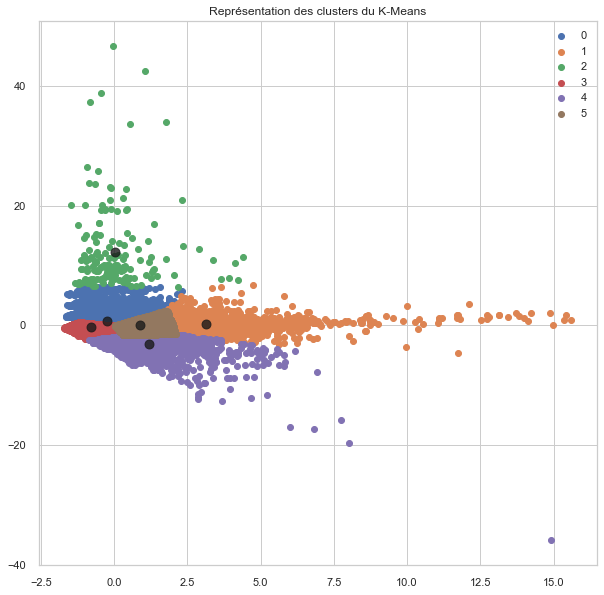

In [121]:
km = KMeans(n_clusters=6, random_state=4)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels_4 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_4:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

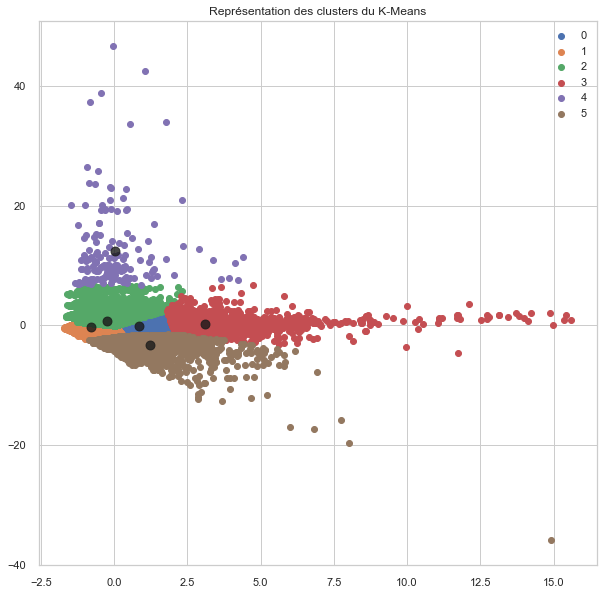

In [122]:
km = KMeans(n_clusters=6, random_state=5)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels_5 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_5:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [123]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [124]:
ari=[]
seed=[2,3,4,5]
ari.append(adjusted_rand_score(u_labels_1, u_labels_2))
ari.append(adjusted_rand_score(u_labels_2, u_labels_3))
ari.append(adjusted_rand_score(u_labels_3, u_labels_4))
ari.append(adjusted_rand_score(u_labels_4, u_labels_5))

df_ari = pd.DataFrame({'ari': ari, 'seed': seed})

<AxesSubplot:xlabel='seed', ylabel='ari'>

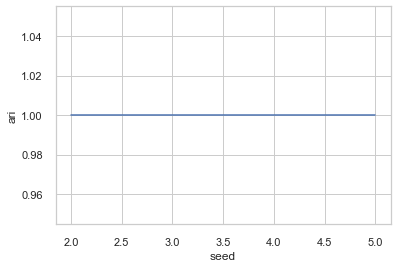

In [125]:
sns.lineplot(data=df_ari, x="seed", y="ari")

In [90]:
data_review["clusters"] = km.labels_
for i in range(0, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° 0  :  16764
Nombre d'individus dans le cluster n° 1  :  32919
Nombre d'individus dans le cluster n° 2  :  2979
Nombre d'individus dans le cluster n° 3  :  33669
Nombre d'individus dans le cluster n° 4  :  1668
Nombre d'individus dans le cluster n° 5  :  4638


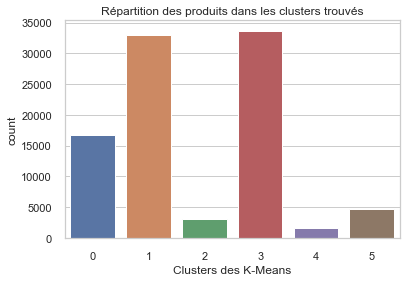

In [91]:
sns.countplot(x="clusters", data=data_review)
plt.xlabel("Clusters des K-Means")
plt.title("Répartition des produits dans les clusters trouvés")
plt.show()

In [92]:
clusters_stats = data_review.groupby("clusters").mean()
clusters_stats

,Récence,Fréquence,Montant,Avis,Delivery_time
clusters,,,,,
0,316.150143,0.000418,173.067572,2.800585,17.261753
1,177.473739,0.000000,147.279436,4.829885,7.325393
2,313.311850,1.000000,73.370902,4.146246,12.542768
3,379.563040,0.000178,107.092754,4.568505,11.751755
4,250.281175,0.000600,1282.981295,3.945444,13.451343
5,309.233721,0.006468,185.908380,1.336244,37.639352


For n_clusters = 6 The average   silhoutte_score is : 0.39804940057712734


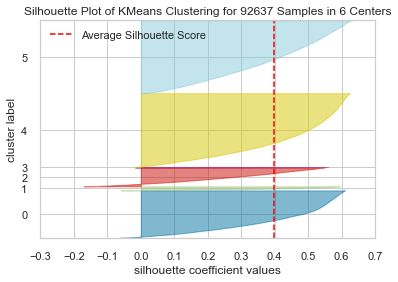

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92637 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [93]:
from yellowbrick.cluster import SilhouetteVisualizer

n_clusters = 6
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)
# The silhouette_score gives the average value for all the   samples.
# Calculating number of clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters, "The average   silhoutte_score is :", silhouette_avg)
# Using Silhouette Plot
visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick')
# Fit the data to the visualizer
visualizer.fit(X)
# Render the figure
visualizer.show()

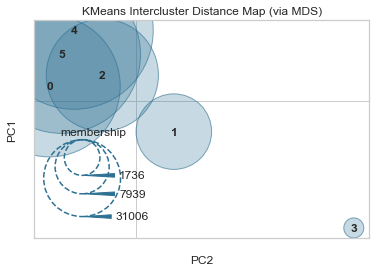

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=6, random_state=10))

In [94]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(6, random_state=10), data_pca)

### Analyse des clusters :

0: Premiers acheteurs seulement avec des avis très élevés et une date d'achat récente 

1: Les clients qui n'ont pas acheté depuis un bon moment (414j)

2: Les clients qui ont acheté plusieurs fois

3: Les clients qui ont fait des commandes très couteuses

4: Les clients mécontents de leurs achats, note à 1,7 / 5

5: Premiers acheteurs moyennement contents (3/5) mais avec des sommes d'achats relativement élevées

### DBScan

In [95]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=15, min_samples=500).fit(X)
cluster = clustering.labels_

In [96]:
data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  46639
Nombre d'individus dans le cluster n° 0  :  45998
Nombre d'individus dans le cluster n° 1  :  0


In [97]:
clustering = DBSCAN(eps=10, min_samples=180).fit(X)
cluster = clustering.labels_

data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  46927
Nombre d'individus dans le cluster n° 0  :  43713
Nombre d'individus dans le cluster n° 1  :  1442
Nombre d'individus dans le cluster n° 2  :  441
Nombre d'individus dans le cluster n° 3  :  114
Nombre d'individus dans le cluster n° 4  :  0


In [98]:
clustering = DBSCAN(eps=30, min_samples=120).fit(X)
cluster = clustering.labels_

data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  5268
Nombre d'individus dans le cluster n° 0  :  87369
Nombre d'individus dans le cluster n° 1  :  0


In [99]:
clustering = DBSCAN(eps=30, min_samples=60).fit(X)
cluster = clustering.labels_

data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  3288
Nombre d'individus dans le cluster n° 0  :  88904
Nombre d'individus dans le cluster n° 1  :  172
Nombre d'individus dans le cluster n° 2  :  153
Nombre d'individus dans le cluster n° 3  :  61
Nombre d'individus dans le cluster n° 4  :  59
Nombre d'individus dans le cluster n° 5  :  0


On peut voir ici que même en changeant les paramètres du modèle il est très difficile d'obtenir des clusters intéressants.
Nous allons donc rester sur notre modèle de K-means pour la suite.

### Segmentation de dates

In [100]:
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,1.000000,credit_card,1.000000,18.120000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574
1,e481f51cbdc54678b7cc49136f2d6af7,3.000000,voucher,1.000000,2.000000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574
2,e481f51cbdc54678b7cc49136f2d6af7,2.000000,voucher,1.000000,18.590000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574
3,53cdb2fc8bc7dce0b6741e2150273451,1.000000,boleto,1.000000,141.460000,8d5266042046a06655c8db133d120ba5,4.000000,2018-08-08 00:00:00,2018-08-08 18:37:50,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,-12.169860,-44.988369,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.782037
4,47770eb9100c2d0c44946d9cf07ec65d,1.000000,credit_card,3.000000,179.120000,e73b67b67587f7644d5bd1a52deb1b01,5.000000,2018-08-18 00:00:00,2018-08-22 19:07:58,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,-16.746337,-48.514624,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.394213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,1.000000,credit_card,3.000000,85.080000,e262b3f92d1ce917aa412a9406cf61a6,5.000000,2017-03-22 00:00:00,2017-03-23 11:02:08,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,sao jose dos campos,-23.172205,-45.880056,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009
104474,63943bddc261676b46f01ca7ac2f7bd8,1.000000,credit_card,3.000000,195.000000,29bb71b2760d0f876dfa178a76bc4734,4.000000,2018-03-01 00:00:00,2018-03-02 17:50:01,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,praia grande,-24.001467,-46.446355,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.193727
104475,83c1379a015df1e13d02aae0204711ab,1.000000,credit_card,5.000000,271.010000,371579771219f6db2d830d50805977bb,5.000000,2017-09-22 00:00:00,2017-09-22 23:10:57,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,-17.891522,-39.370942,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.859421
104476,11c177c8e97725db2631073c19f07b62,1.000000,credit_card,4.000000,441.160000,8ab6855b9fe9b812cd03a480a25058a1,2.000000,2018-01-26 00:00:00,2018-01-27 09:16:56,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,japuiba,-22.555985,-42.690761,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.086424


In [101]:
df = df.drop(['payment_sequential', 'payment_type', 'payment_installments', 'review_id', 'review_creation_date', 'review_answer_timestamp', 'customer_id', 'customer_city', 'geolocation_lat', 'geolocation_lng', 'order_status', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)

In [102]:
df.set_index('customer_unique_id')

,order_id,payment_value,review_score,order_purchase_timestamp,delivery_time
customer_unique_id,,,,,
7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,18.120000,4.000000,2017-10-02 10:56:33,8.436574
7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2.000000,4.000000,2017-10-02 10:56:33,8.436574
7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,18.590000,4.000000,2017-10-02 10:56:33,8.436574
af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,141.460000,4.000000,2018-07-24 20:41:37,13.782037
3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,179.120000,5.000000,2018-08-08 08:38:49,9.394213
...,...,...,...,...,...
6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,85.080000,5.000000,2017-03-09 09:54:05,8.218009
da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,195.000000,4.000000,2018-02-06 12:58:58,22.193727
737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,271.010000,5.000000,2017-08-27 14:46:43,24.859421


In [103]:
first_date

Timestamp('2016-09-04 21:15:19')

In [104]:
last_date

Timestamp('2018-10-17 17:30:18')

In [105]:
date = first_date
cpt_date = 0
while(date < last_date):
    cpt_date += 1
    date = date+relativedelta(months=+1)
print(cpt_date)

26


In [106]:
from dateutil.relativedelta import relativedelta
dataframes = []
for i in range(1, 27):
    dataframes.append(df.loc[df["order_purchase_timestamp"] <= first_date+relativedelta(months=+i)])

In [107]:
df1 = df.loc[df["order_purchase_timestamp"] <= first_date+relativedelta(months=+1)]

In [108]:
dfs = []
for data in dataframes:
    data = data.groupby("customer_unique_id").agg({
        "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
        "order_id" : 'count',
        "payment_value" : "mean",
        "review_score" : "mean",
        "delivery_time" : "mean",
    })    
    data.columns = ["Récence", "Fréquence", "Montant","Avis","Delivery_time"]
    data = data.copy().reset_index()
    data = data.dropna()
    dfs.append(data)


In [109]:
while(len(dfs[0]) < 20000):
    dfs.pop(0)

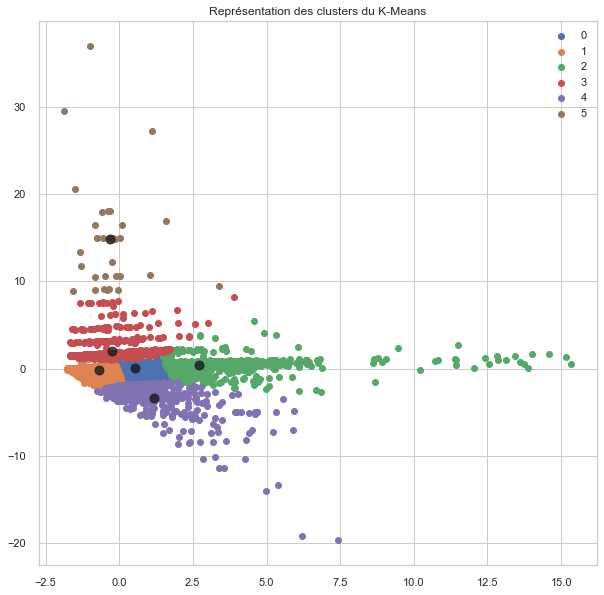

In [110]:
n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data_pca = dfs[0][["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

X = data_pca.values
features = data_pca.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

km = KMeans(n_clusters=6, random_state=1)
label = km.fit_predict(pca_components)
centroids = km.cluster_centers_
u_labels = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()
true_label1 = label

In [111]:
predict_labels = []

for df in dfs:
    data_pca = df[["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

    X = data_pca.values
    features = data_pca.columns
    X_scaled = scaler.fit_transform(X)
    pca_components = pca.fit_transform(X_scaled)
    pcs = pca.components_

    predict_labels.append(km.predict(pca_components))

In [112]:
true_labels = []

for df in dfs:

    data_pca = df[["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

    X = data_pca.values
    features = data_pca.columns
    X_scaled = scaler.fit_transform(X)
    pca_components = pca.fit_transform(X_scaled)
    pcs = pca.components_

    true_labels.append(km.fit_predict(pca_components))

In [113]:
days = []
ari = []
for i in range(len(true_labels)):
    ari.append(adjusted_rand_score(true_labels[i], predict_labels[i]))
    days.append(15*i)
    print("Score ARI pour", 15*i, "jours : ", ari[i])

df_ari = pd.DataFrame({'ari': ari, 'days': days})

Score ARI pour 0 jours :  1.0
Score ARI pour 15 jours :  0.9833055698874715
Score ARI pour 30 jours :  0.9695382663808221
Score ARI pour 45 jours :  0.7761092355245672
Score ARI pour 60 jours :  0.8452287652047081
Score ARI pour 75 jours :  0.5281177334986309
Score ARI pour 90 jours :  0.8144286309463674
Score ARI pour 105 jours :  0.8260728856217878
Score ARI pour 120 jours :  0.9161027303736744
Score ARI pour 135 jours :  0.8831039414148052
Score ARI pour 150 jours :  0.862848499398877
Score ARI pour 165 jours :  0.5266033390714274
Score ARI pour 180 jours :  0.503808942404625
Score ARI pour 195 jours :  0.503808942404625
Score ARI pour 210 jours :  0.503808942404625


<AxesSubplot:xlabel='days', ylabel='ari'>

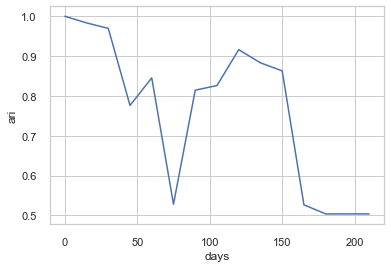

In [114]:
sns.lineplot(data=df_ari, x="days", y="ari")